In [1]:
#Important Imports
import pandas as pd 
#import findspark
#findspark.init()
#findspark.find()
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession

appName = "Twitter Real-time Analytics via Kafka and Spark"
master = "local"
conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1').setAppName(appName).setMaster(master)
sc = SparkContext.getOrCreate(conf=conf)


# If you need to use SQL context, you need to initialize it here.
#sqlContext = SQLContext(sc)

spark = SparkSession.builder \
    .appName("Our Twitter Spark and Kafka example") \
        .getOrCreate()

sc

22/10/26 21:13:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


<SparkContext master=local[*] appName=PySparkShell>

In [5]:
from kafka import KafkaConsumer
import json

topic_name = 'project1'

kafka_consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='latest',
    enable_auto_commit=True,
    auto_commit_interval_ms =  5000,
    fetch_max_bytes = 128,
    max_poll_records = 100,
    value_deserializer=lambda x: x.decode('utf-8'))

In [6]:
word_list=['slowite','bruteforce','floods','malformed']

In [7]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
streamed_data = None
i = 0
for message in kafka_consumer:
    i = i + 1
    if i > 30:
        break
    data = [message.value]
    A=[]
    for j in data:
        res = ""
        for ch in j:
            if ch.isalpha() or ch.isspace():
                res += ch
        A.append(res.lower())
    tweet = spark.createDataFrame(A,"string")
    # clean the tweet and extract the hashtag! 
    # Notice I'm picking one tweet at a time in a separate dataframe to avoid too-large dataframes
    # explode() returns a new row for each element in the given array or map.
    #alias() returns this column aliased with a new name or names

    if streamed_data is None:
        streamed_data = tweet.withColumn('word', explode(split(col('value'), ' '))) \
                    .groupBy('word') \
                    .count() \
                    .sort('count', ascending=False)
    else:
        streamed_data = streamed_data.union(tweet.withColumn('word', explode(split(col('value'), ' '))) \
                    .groupBy('word') \
                    .count() \
                    .sort('count', ascending=False))
    streamed_data1=streamed_data.where(col("word").isin(word_list))
    streamed_data1=streamed_data1.groupBy("word") \
                                .sum("count")
    streamed_data1.show()
                                
#streamed_data1.show()

+------+----------+
|  word|sum(count)|
+------+----------+
|floods|         2|
+------+----------+

+----------+----------+
|      word|sum(count)|
+----------+----------+
|    floods|         2|
|bruteforce|         1|
+----------+----------+

+----------+----------+
|      word|sum(count)|
+----------+----------+
|    floods|         2|
|bruteforce|         1|
|   slowite|         1|
+----------+----------+

+----------+----------+
|      word|sum(count)|
+----------+----------+
|    floods|         2|
|bruteforce|         1|
|   slowite|         1|
| malformed|         1|
+----------+----------+

+----------+----------+
|      word|sum(count)|
+----------+----------+
|    floods|         2|
|bruteforce|         1|
|   slowite|         1|
| malformed|         2|
+----------+----------+

+----------+----------+
|      word|sum(count)|
+----------+----------+
|    floods|         2|
|bruteforce|         1|
|   slowite|         1|
| malformed|         3|
+----------+----------+

+-----

+----------+----------+
|      word|sum(count)|
+----------+----------+
|    floods|        14|
| malformed|         6|
|bruteforce|         2|
|   slowite|         3|
+----------+----------+



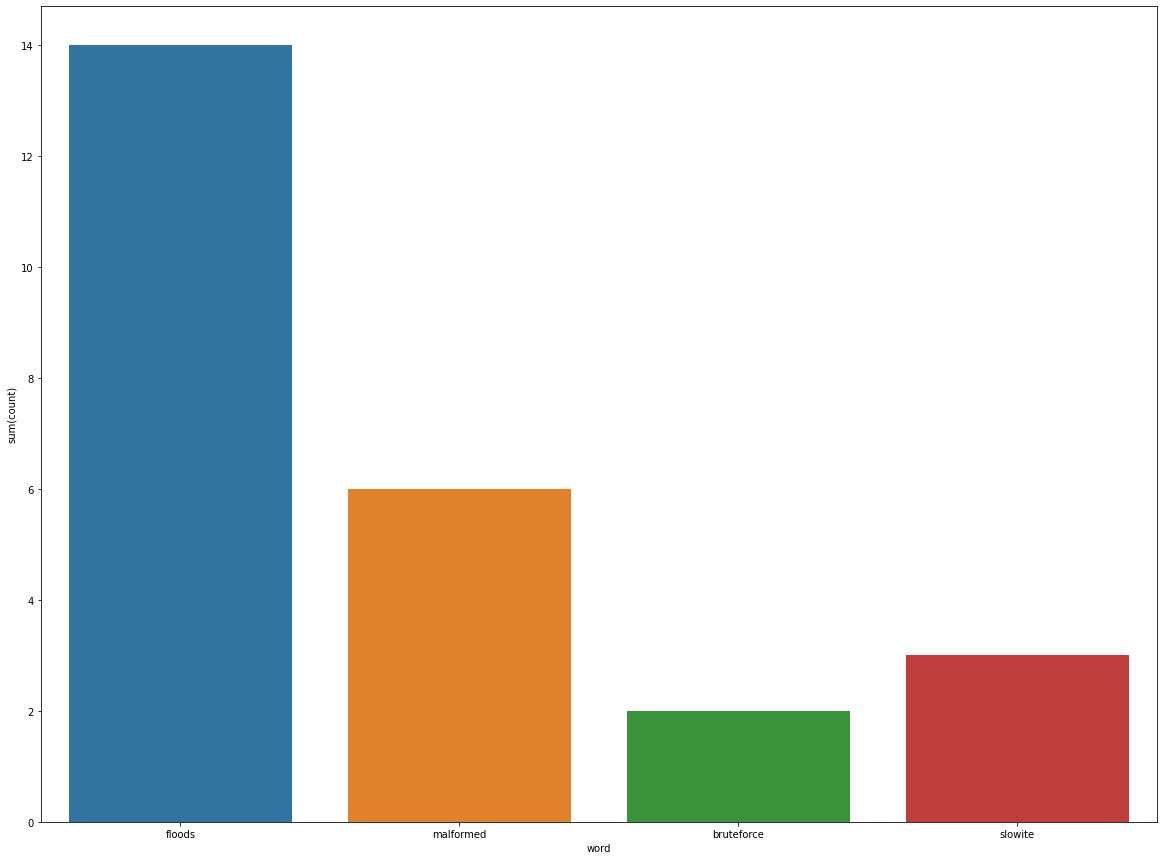

In [5]:
import seaborn as sns
from IPython import display

streamed_data1.show()
dataframe = streamed_data1.toPandas()
import matplotlib.pyplot as plt
plt.figure( figsize = ( 20, 15 ) )
sns.barplot( x="word", y="sum(count)", data=dataframe)
plt.show()